In [1]:
import numpy as np
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#Ссылка на датасет https://www.kaggle.com/datasets/amitamola/mathematics-symbols-data

In [4]:
# Создание и нормализация обучающей, тестовой и выборки валидации

batch_size = 128

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((75, 75)),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_path = "final_symbols_split_ttv/train"
train_ds = datasets.ImageFolder(root=train_path, transform=transform)
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

test_path = "final_symbols_split_ttv/test"
test_ds = datasets.ImageFolder(root=test_path, transform=transform)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

C:\Users\RIEKI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Feature batch shape: torch.Size([128, 3, 75, 75])
Labels batch shape: torch.Size([128])


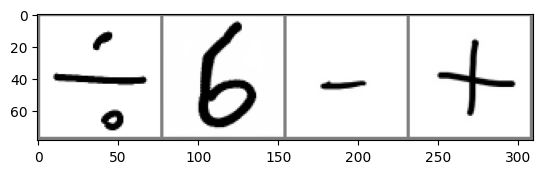

divide	 six	 subtract	 add	


In [6]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
images = []
for i in range(4):
    images.append(train_features[i])
imshow(torchvision.utils.make_grid(images)) # show images
print(' '.join(f'{train_ds.classes[train_labels[j]]}\t' for j in range(4))) # print labels


In [7]:
# Функция формирования набора данных (картинки и метки)
def extract_dataset_images(dataloader):
  labels = []
  images = []
  for batch, batch_labels in tqdm(dataloader):
    images.append(batch.detach().numpy().reshape((batch.shape[0], -1))) # Делаем картинки в виде векторов
    labels.append(batch_labels.detach().numpy())
  return np.concatenate(images), np.concatenate(labels)

In [8]:
x_train, y_train = extract_dataset_images(train_dataloader)
x_test, y_test = extract_dataset_images(test_dataloader)

100%|██████████| 42/42 [00:41<00:00,  1.00it/s]


# KNN

In [9]:
def train_and_test_KNN(x_train, y_train, x_test, y_test, n_neighbors, metric, weights):
  # Обучение KNN на картинках
  knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors, metric = metric, weights = weights)
  knn_classifier.fit(x_train, y_train)

  # Тестирование
  # Классификация тестовых изображений с использованием KNN
  y_pred = knn_classifier.predict(x_test)

  accuracy = accuracy_score(y_test, y_pred)
  return accuracy

In [10]:
def inverse_squared_distance(dist):
    arr = []
    for d in dist:
        arr.append(1 / (d**2))
    return arr

In [11]:
metrics_array = ["minkowski", "euclidean", "cosine"]
weights_array = ["uniform", "distance", inverse_squared_distance]
n_neighbors = [3, 5, 10, 20, 30]

In [12]:
print("KNN accuracy comparison:")
best_accuracy = 0
best_n_neighbors = 0
best_metric = ""
best_weights = ""
for metric in metrics_array:
    for weights in weights_array:
        for n in n_neighbors:
            accuracy = train_and_test_KNN(x_train, y_train, x_test, y_test, n, metric, weights)
            print(f"n_neighbors = {n} \nmetric = {metric} \nweights = {weights} \naccuracy = {accuracy:.3f}")
            print('-'*50)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_n_neighbors = n
                best_metric = metric
                best_weights = weights
print('-'*50)
print("Best KNN accuracy:")
print(f"n_neighbors = {best_n_neighbors} \nmetric = {best_metric} \nweights = {best_weights} \naccuracy = {best_accuracy}")

KNN accuracy comparison:
n_neighbors = 3 
metric = minkowski 
weights = uniform 
accuracy = 0.781
--------------------------------------------------
n_neighbors = 5 
metric = minkowski 
weights = uniform 
accuracy = 0.765
--------------------------------------------------
n_neighbors = 10 
metric = minkowski 
weights = uniform 
accuracy = 0.733
--------------------------------------------------
n_neighbors = 20 
metric = minkowski 
weights = uniform 
accuracy = 0.698
--------------------------------------------------
n_neighbors = 30 
metric = minkowski 
weights = uniform 
accuracy = 0.672
--------------------------------------------------
n_neighbors = 3 
metric = minkowski 
weights = distance 
accuracy = 0.791
--------------------------------------------------
n_neighbors = 5 
metric = minkowski 
weights = distance 
accuracy = 0.773
--------------------------------------------------
n_neighbors = 10 
metric = minkowski 
weights = distance 
accuracy = 0.743
---------------------------

C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 3 
metric = minkowski 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40> 
accuracy = 0.793
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 5 
metric = minkowski 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40> 
accuracy = 0.775
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 10 
metric = minkowski 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40> 
accuracy = 0.745
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 20 
metric = minkowski 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40> 
accuracy = 0.708
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 30 
metric = minkowski 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40> 
accuracy = 0.684
--------------------------------------------------
n_neighbors = 3 
metric = euclidean 
weights = uniform 
accuracy = 0.781
--------------------------------------------------
n_neighbors = 5 
metric = euclidean 
weights = uniform 
accuracy = 0.765
--------------------------------------------------
n_neighbors = 10 
metric = euclidean 
weights = uniform 
accuracy = 0.733
--------------------------------------------------
n_neighbors = 20 
metric = euclidean 
weights = uniform 
accuracy = 0.698
--------------------------------------------------
n_neighbors = 30 
metric = euclidean 
weights = uniform 
accuracy = 0.672
--------------------------------------------------
n_neighbors = 3 
metric = euclidean 
weights = distance 
accuracy = 0.791
--------------------------------------------------
n_neighbors = 5 
metric = euclidean 
weights = distance 
accuracy = 0.773
---

C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 3 
metric = euclidean 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40> 
accuracy = 0.793
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 5 
metric = euclidean 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40> 
accuracy = 0.775
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 10 
metric = euclidean 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40> 
accuracy = 0.745
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 20 
metric = euclidean 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40> 
accuracy = 0.708
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 30 
metric = euclidean 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40> 
accuracy = 0.684
--------------------------------------------------
n_neighbors = 3 
metric = cosine 
weights = uniform 
accuracy = 0.776
--------------------------------------------------
n_neighbors = 5 
metric = cosine 
weights = uniform 
accuracy = 0.757
--------------------------------------------------
n_neighbors = 10 
metric = cosine 
weights = uniform 
accuracy = 0.726
--------------------------------------------------
n_neighbors = 20 
metric = cosine 
weights = uniform 
accuracy = 0.690
--------------------------------------------------
n_neighbors = 30 
metric = cosine 
weights = uniform 
accuracy = 0.661
--------------------------------------------------
n_neighbors = 3 
metric = cosine 
weights = distance 
accuracy = 0.790
--------------------------------------------------
n_neighbors = 5 
metric = cosine 
weights = distance 
accuracy = 0.768
------------------------

C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 3 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40> 
accuracy = 0.792
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 5 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40> 
accuracy = 0.774
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 10 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40> 
accuracy = 0.748
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 20 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40> 
accuracy = 0.715
--------------------------------------------------
n_neighbors = 30 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40> 
accuracy = 0.686
--------------------------------------------------
--------------------------------------------------
Best KNN accuracy:
n_neighbors = 3 
metric = minkowski 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40> 
accuracy = 0.792755787901419


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


# PCA+KNN

In [13]:
def train_and_test_PCA_KNN(x_train, y_train, x_test, y_test, n_components, knn_classifier):
  pca = PCA(n_components=n_components)
  x_train_pca = pca.fit_transform(x_train)
  knn_classifier.fit(x_train_pca, y_train)

  # Тестирование
  # Применение созданного ранее PCA для тестовых данных
  x_test_pca = pca.transform(x_test)
  # Классификация тестовых изображений с использованием KNN
  y_pred = knn_classifier.predict(x_test_pca)
  accuracy = accuracy_score(y_test, y_pred)
  return accuracy

In [14]:
n_components = [10, 50, 100, 200, 500, 700]

In [15]:
print("KNN + PCA accuracy comparison:")
best_accuracy = 0
best_n_neighbors = 0
best_metric = ""
best_weights = ""
best_n_components = 0

for metric in metrics_array:
    for weights in weights_array:
        for n_n in n_neighbors:
            for n_c in n_components:
                knn_classifier = KNeighborsClassifier(n_neighbors=n_n, metric = metric, weights = weights)
                accuracy = train_and_test_PCA_KNN(x_train, y_train, x_test, y_test, n_c, knn_classifier)
                print(f"n_neighbors = {n_n} \nmetric = {metric} \nweights = {weights}")
                print(f"n_components = {n_c} \naccuracy = {accuracy:.3f}")
                print('-'*50)
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_n_neighbors = n_n
                    best_metric = metric
                    best_weights = weights
                    best_n_components = n_c
print('-'*50)
print("Best PCA+KNN accuracy:")
print(f"n_neighbors = {best_n_neighbors} \nmetric = {best_metric} \nweights = {best_weights}")
print(f"n_components = {best_n_components} \naccuracy = {best_accuracy:.3f}")

KNN + PCA accuracy comparison:
n_neighbors = 3 
metric = minkowski 
weights = uniform
n_components = 10 
accuracy = 0.834
--------------------------------------------------
n_neighbors = 3 
metric = minkowski 
weights = uniform
n_components = 50 
accuracy = 0.912
--------------------------------------------------
n_neighbors = 3 
metric = minkowski 
weights = uniform
n_components = 100 
accuracy = 0.887
--------------------------------------------------
n_neighbors = 3 
metric = minkowski 
weights = uniform
n_components = 200 
accuracy = 0.850
--------------------------------------------------
n_neighbors = 3 
metric = minkowski 
weights = uniform
n_components = 500 
accuracy = 0.807
--------------------------------------------------
n_neighbors = 3 
metric = minkowski 
weights = uniform
n_components = 700 
accuracy = 0.801
--------------------------------------------------
n_neighbors = 5 
metric = minkowski 
weights = uniform
n_components = 10 
accuracy = 0.839
----------------------

C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 3 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 10 
accuracy = 0.827
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 3 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 50 
accuracy = 0.928
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 3 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 100 
accuracy = 0.908
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 3 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 200 
accuracy = 0.883
--------------------------------------------------
n_neighbors = 3 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 500 
accuracy = 0.860
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 3 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 700 
accuracy = 0.853
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 5 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 10 
accuracy = 0.836
--------------------------------------------------
n_neighbors = 5 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 50 
accuracy = 0.922
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 5 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 100 
accuracy = 0.905
--------------------------------------------------
n_neighbors = 5 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 200 
accuracy = 0.878
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 5 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 500 
accuracy = 0.855
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 5 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 700 
accuracy = 0.853
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 10 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 10 
accuracy = 0.836
--------------------------------------------------
n_neighbors = 10 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 50 
accuracy = 0.911
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 10 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 100 
accuracy = 0.890
--------------------------------------------------
n_neighbors = 10 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 200 
accuracy = 0.864
--------------------------------------------------
n_neighbors = 10 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 500 
accuracy = 0.845
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 10 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 700 
accuracy = 0.838
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 20 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 10 
accuracy = 0.832
--------------------------------------------------
n_neighbors = 20 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 50 
accuracy = 0.895
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 20 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 100 
accuracy = 0.870
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 20 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 200 
accuracy = 0.843
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 20 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 500 
accuracy = 0.818
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 20 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 700 
accuracy = 0.812
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 30 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 10 
accuracy = 0.824
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 30 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 50 
accuracy = 0.884
--------------------------------------------------
n_neighbors = 30 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 100 
accuracy = 0.857
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 30 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 200 
accuracy = 0.828
--------------------------------------------------
n_neighbors = 30 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 500 
accuracy = 0.806
--------------------------------------------------
n_neighbors = 30 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 700 
accuracy = 0.801
--------------------------------------------------
--------------------------------------------------
Best PCA+KNN accuracy:
n_neighbors = 3 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 50 
accuracy = 0.928


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


# CNN+PCA+KNN

In [16]:
from torchvision.models import alexnet
model = alexnet(pretrained=True)
model.classifier = nn.Flatten(start_dim= 1)
model.to(device)

C:\Users\RIEKI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\RIEKI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\RIEKI/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:18

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Flatten(start_dim=1, end_dim=-1)
)

In [17]:
def extract_features(dataset, model):
    features = []
    labels = []
    for batch_images, batch_labels in tqdm(dataset):
        batch_features = model(batch_images.to(device))
        labels.append(batch_labels.detach().numpy())
        features.append(batch_features.cpu().detach().numpy())
    return np.concatenate(features), np.concatenate(labels)

In [18]:
x_train_features, y_train_labels = extract_features(train_dataloader, model)
x_test_features, y_test_labels = extract_features(test_dataloader, model)

  0%|          | 0/334 [00:00<?, ?it/s]C:\Users\RIEKI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 42/42 [00:41<00:00,  1.01it/s]


In [19]:
print("KNN + PCA + CNN accuracy comparison:")
best_accuracy = 0
best_n_neighbors = 0
best_metric = ""
best_weights = ""
best_n_components = 0

for metric in metrics_array:
    for weights in weights_array:
        for n_n in n_neighbors:
            for n_c in n_components:
                knn_classifier = KNeighborsClassifier(n_neighbors=n_n, metric = metric, weights = weights)
                accuracy = train_and_test_PCA_KNN(x_train_features, y_train_labels, x_test_features, y_test_labels, n_c, knn_classifier)
                print(f"n_neighbors = {n_n} \nmetric = {metric} \nweights = {weights}")
                print(f"n_components = {n_c} \naccuracy = {accuracy:.3f}")
                print('-'*50)
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_n_neighbors = n_n
                    best_metric = metric
                    best_weights = weights
                    best_n_components = n_c
print('-'*50)
print("Best PCA+KNN+CNN accuracy:")
print(f"n_neighbors = {best_n_neighbors} \nmetric = {best_metric} \nweights = {best_weights}")
print(f"n_components = {best_n_components} \naccuracy = {best_accuracy:.3f}")

KNN + PCA + CNN accuracy comparison:
n_neighbors = 3 
metric = minkowski 
weights = uniform
n_components = 10 
accuracy = 0.817
--------------------------------------------------
n_neighbors = 3 
metric = minkowski 
weights = uniform
n_components = 50 
accuracy = 0.931
--------------------------------------------------
n_neighbors = 3 
metric = minkowski 
weights = uniform
n_components = 100 
accuracy = 0.945
--------------------------------------------------
n_neighbors = 3 
metric = minkowski 
weights = uniform
n_components = 200 
accuracy = 0.948
--------------------------------------------------
n_neighbors = 3 
metric = minkowski 
weights = uniform
n_components = 500 
accuracy = 0.949
--------------------------------------------------
n_neighbors = 3 
metric = minkowski 
weights = uniform
n_components = 700 
accuracy = 0.949
--------------------------------------------------
n_neighbors = 5 
metric = minkowski 
weights = uniform
n_components = 10 
accuracy = 0.828
----------------

C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 3 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 10 
accuracy = 0.813
--------------------------------------------------
n_neighbors = 3 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 50 
accuracy = 0.940
--------------------------------------------------
n_neighbors = 3 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 100 
accuracy = 0.950
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 3 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 200 
accuracy = 0.953
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 3 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 500 
accuracy = 0.952
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 3 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 700 
accuracy = 0.952
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 5 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 10 
accuracy = 0.823
--------------------------------------------------
n_neighbors = 5 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 50 
accuracy = 0.942
--------------------------------------------------
n_neighbors = 5 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 100 
accuracy = 0.950
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 5 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 200 
accuracy = 0.953
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 5 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 500 
accuracy = 0.953
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 5 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 700 
accuracy = 0.953
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 10 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 10 
accuracy = 0.830
--------------------------------------------------
n_neighbors = 10 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 50 
accuracy = 0.940
--------------------------------------------------
n_neighbors = 10 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 100 
accuracy = 0.948
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 10 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 200 
accuracy = 0.948
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 10 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 500 
accuracy = 0.948
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 10 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 700 
accuracy = 0.948
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 20 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 10 
accuracy = 0.828
--------------------------------------------------
n_neighbors = 20 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 50 
accuracy = 0.931
--------------------------------------------------
n_neighbors = 20 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 100 
accuracy = 0.938
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 20 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 200 
accuracy = 0.941
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 20 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 500 
accuracy = 0.941
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 20 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 700 
accuracy = 0.941
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 30 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 10 
accuracy = 0.827
--------------------------------------------------
n_neighbors = 30 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 50 
accuracy = 0.923
--------------------------------------------------
n_neighbors = 30 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 100 
accuracy = 0.933
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 30 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 200 
accuracy = 0.936
--------------------------------------------------


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


n_neighbors = 30 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 500 
accuracy = 0.936
--------------------------------------------------
n_neighbors = 30 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 700 
accuracy = 0.936
--------------------------------------------------
--------------------------------------------------
Best PCA+KNN+CNN accuracy:
n_neighbors = 5 
metric = cosine 
weights = <function inverse_squared_distance at 0x0000015B08DBFF40>
n_components = 200 
accuracy = 0.953


C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))


In [20]:
knn_classifier = KNeighborsClassifier(n_neighbors=best_n_neighbors, metric=best_metric, weights=best_weights)
pca = PCA(n_components=best_n_components)

x_train_pca = pca.fit_transform(x_train_features)
knn_classifier.fit(x_train_pca, y_train_labels)

x_test_pca = pca.transform(x_test_features)
y_pred = knn_classifier.predict(x_test_pca)

print(classification_report(y_test_labels, y_pred, target_names=test_ds.classes))

              precision    recall  f1-score   support

         add       0.97      0.98      0.98       355
      divide       0.98      0.99      0.99       330
       eight       0.91      0.94      0.93       348
        five       0.90      0.94      0.92       354
        four       0.95      0.92      0.94       399
    multiply       0.97      0.99      0.98       395
        nine       0.94      0.94      0.94       403
         one       0.97      0.98      0.98       455
       seven       0.96      0.91      0.93       407
         six       0.96      0.90      0.93       373
    subtract       0.99      1.00      1.00       432
       three       0.93      0.93      0.93       324
         two       0.95      0.94      0.95       480
        zero       0.94      0.97      0.95       301

    accuracy                           0.95      5356
   macro avg       0.95      0.95      0.95      5356
weighted avg       0.95      0.95      0.95      5356



C:\Users\RIEKI\AppData\Local\Temp\ipykernel_6004\4162778230.py:4: RuntimeWarning: divide by zero encountered in divide
  arr.append(1 / (d**2))
